In [1]:
import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import optax
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')
from prophet_utils.plot_utils import plot_non_iid_instance

In [2]:
m = 50
n = 2

r_odd = jnp.tile(jnp.arange(m), (n, 1))/m
p_odd = jnp.ones((n, m))/m

In [3]:
#jnp_file = jnp.load("../instances/free_order_0.74620_500_50_2000_0.1.npz")

#r_odd = jnp_file['arr_0']
#p_odd = jnp_file['arr_1']

In [4]:
N = 100 # Big N is the actual number of boxes

In [5]:
permutations_odd = jnp.identity(N, dtype=int)

In [6]:
from prophet_utils.non_iid_utils import expected_maximum

def expected_maximum_odd(realizations, probabilities, N_prime):
    p1 = probabilities[0]

    def f(p, p_i):
        p_new = p + p_i
        p_j = (p_new**N_prime - p**N_prime)
        return p_new, p_j

    _, p_y = jax.lax.scan(f, 0, p1) # First get the distribution of Y = max(X1, ..., X_n-1)
    return expected_maximum(realizations, jnp.asarray([p_y, probabilities[1]]))  # Then calculate E[max(Y, X_n)].


In [7]:
from prophet_utils.iid_utils import pos_test_probabilities, conditional_expected_values

perms = jnp.arange(N)

def optimal_strategy_odd(realizations, probabilities, permutations, N):
    r1, r2 = realizations[0], realizations[1]
    p1, p2 = probabilities[0], probabilities[1]

    ev = jnp.sum(r1*p1)
    
    pos_test_prbs1 = pos_test_probabilities(p1)
    cond_exp_value1, _ = conditional_expected_values(r1, p1, pos_test_prbs1)

    pos_test_prbs2 = pos_test_probabilities(p2)
    cond_exp_value2, _ = conditional_expected_values(r2, p2, pos_test_prbs2)

    def f(ev_remaining, _):
        j = jnp.min(jnp.where(r1 >= ev_remaining, jnp.arange(r1.shape[0]), r1.shape[0]))  # This is the smallest index whose corresponding realization is at least ev_opt.
        p = pos_test_prbs1[j]
        ev_remaining = p*cond_exp_value1[j] + (1-p)*ev_remaining
        return ev_remaining, ev_remaining

    _, evs_remaining = jax.lax.scan(f, ev, None, length=N-2)
    evs_remaining = jnp.concatenate((jnp.array([0, ev]), evs_remaining))  # Insert a zero at the beginning.

    def optimal_strategy(i):
        ev_i = evs_remaining[i]

        j = jnp.min(jnp.where(r2 >= ev_i, jnp.arange(r2.shape[0]), r2.shape[0]))  # This is the smallest index whose corresponding realization is at least ev_opt.
        p = pos_test_prbs2[j]
        ev_i = p*cond_exp_value2[j] + (1-p)*ev_i

        _, evs_remaining_i_scanned = jax.lax.scan(f, ev_i, None, length=N-1)

        evs_remaining_i_scanned = jnp.concatenate((jnp.array([ev_i]), evs_remaining_i_scanned))
        return evs_remaining_i_scanned[N-i-1]

    vs = jax.vmap(optimal_strategy)(permutations)
    return jnp.mean(vs)  # or jnp.max()


In [8]:
from prophet_utils.non_iid_utils import normalize_boxes

def competitive_ratio_odd_one(realizations, probabilities, permutations, N):
    N_prime = len(permutations) - 1
    return optimal_strategy_odd(realizations, probabilities, permutations, N)/expected_maximum_odd(realizations, probabilities, N_prime)


def competitive_ratio_odd_one_normalized(realizations, probabilities, permutations, N):
    return competitive_ratio_odd_one(*normalize_boxes(realizations, probabilities), permutations, N)

competitive_ratio_odd_one_normalized_jit = jax.jit(competitive_ratio_odd_one_normalized, static_argnums=(3))

In [9]:
competitive_ratio_odd_one_normalized_jit(r_odd, p_odd, perms, N)  #0.85378948

Array(0.99420055, dtype=float64)

In [10]:
optimizer_odd = optax.adam(learning_rate=0.1) 
opt_state_odd = optimizer_odd.init((r_odd, p_odd))

for i in range(500):
    v_odd, grads = jax.value_and_grad(competitive_ratio_odd_one_normalized, argnums=(0,1))(r_odd, p_odd, perms, N) #(r_odd, p_odd, permutations_odd) # (r_odd, p_odd, perms, N) #permutations
    updates_odd, opt_state_odd = optimizer_odd.update(grads, opt_state_odd)
    r_odd, p_odd = optax.apply_updates((r_odd, p_odd), updates_odd)
    if i%100 == 0:
        print(v_odd)

print(competitive_ratio_odd_one_normalized(r_odd, p_odd, perms, N))


0.9942005500692106
0.7293518260783887
0.7276989658719858
0.7271436234322686
0.7269402787521532
0.7267926870121774


In [11]:
#jax.numpy.savez(f"free_order_{v_odd:.5f}_{N + N_add}_{m}_{0.1}.npz", r_odd, p_odd)

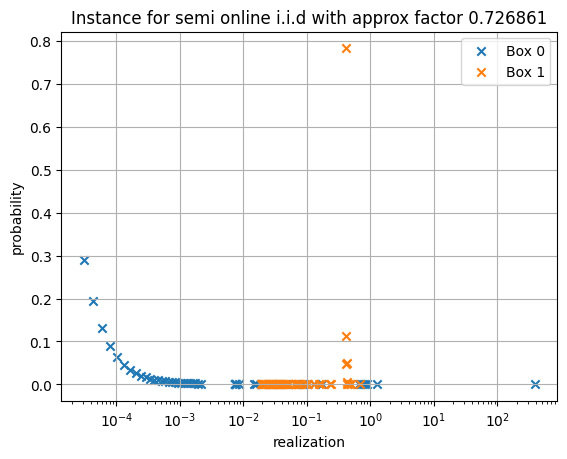

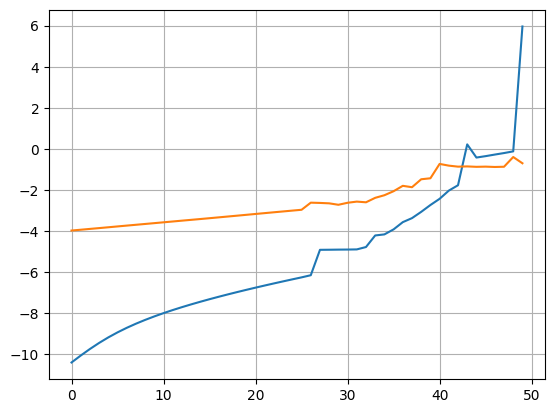

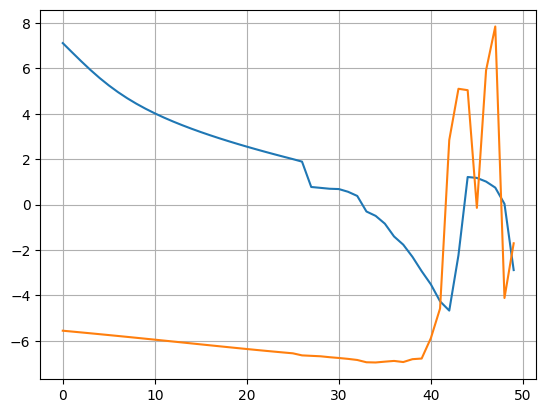

In [12]:
from prophet_utils.plot_utils import plot_non_iid_instance

r_normed, p_normed = normalize_boxes(r_odd, p_odd)

plot_non_iid_instance(r_normed, p_normed, v_odd)
plt.show()

plt.plot(r_odd[0])
plt.plot(r_odd[1])
plt.grid()
plt.show()

plt.plot(p_odd[0])
plt.plot(p_odd[1])
plt.grid()
plt.show()
